In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from finrl.plot import convert_daily_return_to_pyfolio_ts
from pyfolio import timeseries
import os

def analyze_and_plot_returns(base_folder):
    # Define subfolders and filenames
    paths = {
        'A2C': f"{base_folder}/a2c/a2c_daily_return.csv",
        'DDPG': f"{base_folder}/ddpg/ddpg_daily_return.csv",
        'PPO': f"{base_folder}/ppo/ppo_daily_return.csv",
        'SAC': f"{base_folder}/sac/sac_daily_return.csv",
        'TD3': f"{base_folder}/td3/td3_daily_return.csv",
        'Ensemble': f"{base_folder}/df_daily_return_ensemble.csv",
        'Naive': f"{base_folder}/naive/df_daily_return_naive.csv",
        'Min': f"{base_folder}/min/df_daily_return_min.csv",
        'Mean': f"{base_folder}/mvo/df_daily_return_mvo.csv",
        'Adaptive-Mean': f"{base_folder}/adaptive_mvo/df_daily_return_adaptive_mvo.csv"
    }

    return_dfs = []
    agent_names = []

    # Load CSV files dynamically
    for name, path in paths.items():
        if os.path.exists(path):
            df = pd.read_csv(path, parse_dates=["date"])
            return_dfs.append(df)
            agent_names.append(name)
        else:
            print(f"[Warning] File not found for {name}: {path}")

    # Calculate and print performance stats
    for i, df_return in enumerate(return_dfs):
        strat = convert_daily_return_to_pyfolio_ts(df_return)
        stats = timeseries.perf_stats(strat)
        print(f"\nPerformance Stats for {agent_names[i]}:\n")
        print(stats)

    # Plot cumulative return
    plt.figure(figsize=(14, 7))
    for df, name in zip(return_dfs, agent_names):
        strat = convert_daily_return_to_pyfolio_ts(df)
        cum_return = (1 + strat).cumprod() - 1
        plt.plot(cum_return.index, cum_return.values, label=name)

    plt.title("Cumulative Return Comparison")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
analyze_and_plot_returns(base_folder="2007-2025_no_crypto")



Performance Stats for A2C:

Annual return          0.124103
Cumulative returns     0.264193
Annual volatility      0.120441
Sharpe ratio           1.031450
Calmar ratio           0.941616
Stability              0.906639
Max drawdown          -0.131797
Omega ratio            1.197446
Sortino ratio          1.551664
Skew                   0.558246
Kurtosis               9.356877
Tail ratio             1.052188
Daily value at risk   -0.014681
dtype: float64

Performance Stats for DDPG:

Annual return          0.178419
Cumulative returns     0.389577
Annual volatility      0.128544
Sharpe ratio           1.341581
Calmar ratio           1.585477
Stability              0.927624
Max drawdown          -0.112533
Omega ratio            1.254921
Sortino ratio          2.076112
Skew                   0.387732
Kurtosis               4.785854
Tail ratio             1.164639
Daily value at risk   -0.015511
dtype: float64

Performance Stats for PPO:

Annual return          0.145604
Cumulative returns

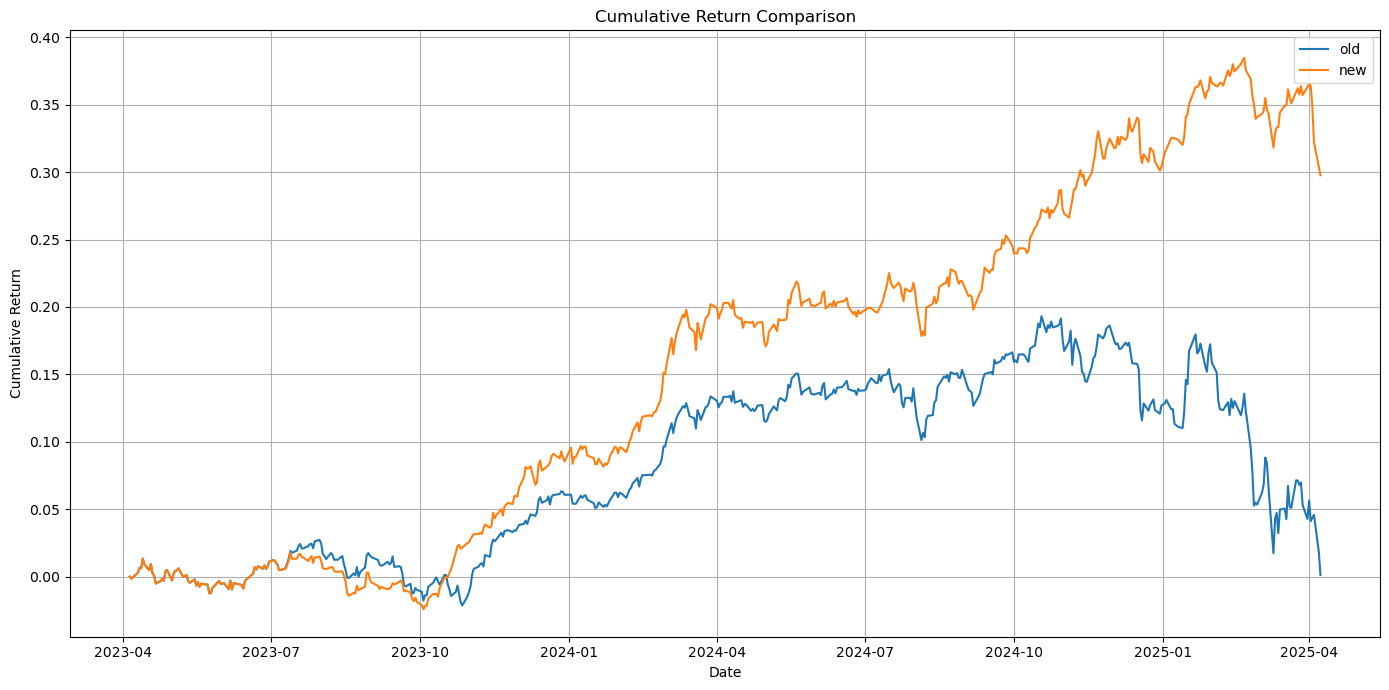

In [60]:
# Plot cumulative return
plt.figure(figsize=(14, 7))
for df, name in zip(return_dfs, agent_names):
    # Convert to pyfolio ts and calculate cumulative return
    strat = convert_daily_return_to_pyfolio_ts(df)
    cum_return = (1 + strat).cumprod() - 1
    plt.plot(cum_return.index, cum_return.values, label=name)

plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from finrl.plot import convert_daily_return_to_pyfolio_ts

# Load daily return files
df_daily_return_1 = pd.read_csv("df_daily_return_adaptive_mvo.csv", parse_dates=["date"])
df_daily_return_2 = pd.read_csv("adaptive_mvo_2024_2025.csv", parse_dates=["date"])



In [58]:
from pyfolio import timeseries

return_dfs = [df_daily_return_1, df_daily_return_2]
agent_names = ['old', 'new']

for i, df_return in enumerate(return_dfs):
    strat = convert_daily_return_to_pyfolio_ts(df_return)
    stats = timeseries.perf_stats(strat)
    print(f"\nPerformance Stats for {agent_names[i]}:\n")
    print(stats)



Performance Stats for old:

Annual return          0.000562
Cumulative returns     0.001124
Annual volatility      0.102248
Sharpe ratio           0.056749
Calmar ratio           0.003490
Stability              0.604366
Max drawdown          -0.160918
Omega ratio            1.010624
Sortino ratio          0.074126
Skew                  -1.027877
Kurtosis               7.314776
Tail ratio             0.865723
Daily value at risk   -0.012859
dtype: float64

Performance Stats for new:

Annual return          0.139146
Cumulative returns     0.297654
Annual volatility      0.079785
Sharpe ratio           1.673132
Calmar ratio           2.213662
Stability              0.948210
Max drawdown          -0.062858
Omega ratio            1.326983
Sortino ratio          2.471090
Skew                  -0.327692
Kurtosis               1.806920
Tail ratio             1.159498
Daily value at risk   -0.009522
dtype: float64
